Andy Nguyen, Michael Wolfe, Spencer Fogelman, Joseph Caguioa

DS 7331-407

Thursday 6:30 - 8:00 PM

<center><h1>Lab 3: Cluster Analysis of AirBnb listings in major U.S. cities</h1></center>

<a id='top'></a>
# Rubric / Table of Contents

* [Business Understanding 1](#business_understanding) (10 pts)
* [Data Understanding 1](#data_understanding_1) (10 pts)
* [Data Understanding 2](#data_understanding_2) (10 pts)
* [Modeling and Evaluation 1](#modeling_evaluation_1) (10 pts)
* [Modeling and Evaluation 2](#modeling_evaluation_2) (10 pts)
* [Modeling and Evaluation 3](#modeling_evaluation_3) (10 pts)
* [Modeling and Evaluation 4](#modeling_evaluation_4) (20 pts)
* [Deployment](#deployment) (10 pts)
* [Exceptional Work](#exceptional_work) (10 pts)

## Introduction

*Dataset Source: https://www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml*

This Kaggle dataset contains data on AirBnb listings for 6 major U.S. cities (CHI, DC, LA, NYC, SF, BOS). The competition's original objective was to use the provided attributes to predict the price of a listing. However, the dataset can be adjusted to predict other variables as well.

In this notebook, we will use the data on these AirBnb listings to practice clustering algorithms to extract new features from the available data. We will use these new features to build new classifiers and assess any improvements in performance compared to the classification models in our previous notebook.

### Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import csv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings

#from plotnine import *
%matplotlib inline
warnings.filterwarnings('ignore')

In [72]:
def EncodeCategory(col_to_encode):
    distinct_cats = col_to_encode.unique()
    encode_list = []
    i = 1
    for cat in distinct_cats:
        encode_list.append([cat,i])    
        i += 1
    return(encode_list)

### Data Preparation

In [3]:
# Load dataset
df = pd.read_csv('https://raw.githubusercontent.com/anguyen-07/DS7331-ML_Labs/master/data/airbnb_train.csv')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [5]:
df['price'] = np.exp(df['log_price'])
df['grade'] = pd.cut(df.review_scores_rating, [0,60,70,80,90,101], right=False, labels = ['F', 'D', 'C', 'B', 'A'])
df[['grade', 'review_scores_rating']].head()

,grade,review_scores_rating
0,A,100.0
1,A,93.0
2,A,92.0
3,NaN,NaN
4,F,40.0


In [6]:
# Clean up datatypes and duplicates
df_ratings = df.dropna(subset=['review_scores_rating'])
df_ratings.drop_duplicates(inplace=True)
floats = ['log_price','bathrooms','latitude','longitude','review_scores_rating', 'price']
df_ratings[floats] = df_ratings[floats].astype(np.float64)
ints = ['id','accommodates','number_of_reviews','bedrooms','beds']
df_ratings["host_response_rate"] = df_ratings["host_response_rate"].str.rstrip('%').astype(np.float64)/100
date_time = ['first_review','host_since','last_review']
df_ratings[date_time] = df_ratings[date_time].apply(pd.to_datetime)
booleans = ['host_has_profile_pic','host_identity_verified','instant_bookable']
df_ratings[booleans] = df_ratings[booleans].replace({'t':True,'f':False})
df_ratings[booleans] = df_ratings[booleans].astype(np.bool)
categorical = ['property_type','room_type','bed_type','cancellation_policy','city','neighbourhood','zipcode']
df_ratings[categorical] = df_ratings[categorical].astype('category')
df_ratings.drop_duplicates()
df_ratings.host_since[df_ratings.host_since.isna()] = df_ratings.first_review[df_ratings.host_since.isna()]

In [7]:
# Impute missing values
df_imputed = df_ratings
df_imputed["bathrooms"] = df_imputed["bathrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bathrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["bedrooms"] = df_imputed["bedrooms"].fillna(df_imputed.groupby(["property_type","accommodates"])["bedrooms"].apply(lambda x : x.fillna(x.median())))
df_imputed["beds"] = df_imputed["beds"].fillna(df_imputed.groupby(["property_type","accommodates"])["beds"].apply(lambda x : x.fillna(x.median())))
df_imputed["host_response_rate"] = df_imputed["host_response_rate"].fillna(df_imputed.groupby(["number_of_reviews"])["host_response_rate"].apply(lambda x : x.fillna(x.mean())))
# Impute Missing Value of for 100% Host Response Rate for Row 48194 - Private Room in Apartment
df_imputed["host_response_rate"][df_imputed["host_response_rate"].isna()] = 1.0
df_imputed[ints] = df_imputed[ints].astype(np.int64)

In [8]:
import re
#Create a new cleaned amenities column where all amenities are in list form
df_imputed['amenities_new'] = df_imputed.apply(lambda row: re.sub(r'[{}""]', '', row['amenities']), axis=1)
df_imputed['amenities_new'] = df_imputed.apply(lambda row: row['amenities_new'].lower().split(','), axis=1)
df_imputed = df_imputed.reset_index()
df_imputed['length_amenities'] = df_imputed.apply(lambda row: len(row['amenities_new']), axis=1)

# Create separate columns based on amenities
df_imputed['internet'] = df_imputed.apply(lambda row: 'internet' in row.amenities.lower(), axis=1)
df_imputed['TV'] = df_imputed.apply(lambda row: 'tv' in row.amenities.lower(), axis=1)
df_imputed['air_conditioning'] = df_imputed.apply(lambda row: 'air conditioning' in row.amenities.lower(), axis=1)
df_imputed['kitchen'] = df_imputed.apply(lambda row: 'kitchen' in row.amenities.lower(), axis=1)
df_imputed['pool'] = df_imputed.apply(lambda row: 'pool' in row.amenities.lower(), axis=1)
df_imputed['parking'] = df_imputed.apply(lambda row: 'parking' in row.amenities.lower(), axis=1)

# Get information from description based on length in characters
df_imputed['description_length'] = df_imputed['description'].apply(len)

# Create the target variable superuser
df_imputed['superuser'] = False
df_imputed.loc[df.review_scores_rating >=96, 'superuser'] = True

# Create altnerative target variable grade_grouped
new_grades = {
    'A':'A',
    'B':'<A',
    'C':'<A',
    'D':'<A',
    'F':'<A'
}
df_imputed['grade_grouped'] = df_imputed['grade'].map(new_grades)

In [9]:
import datetime
date_published = datetime.datetime(2018,3,14)
df_imputed['host_since'] = pd.to_datetime(df_imputed['host_since'])
df_imputed['host_since_days'] = df_imputed.apply(lambda row: (date_published - row['host_since']).days, axis=1)

**Removed columns that are not meaningful in a modeling context (i.e., index,id), redundant with newly engineered features (i.e., amenities, description), or are likenly not useful in predicting the target variable grade_grouped.**

In [10]:
# delete useless columns
df_logistic = df_imputed.drop(['index','id','amenities','description','zipcode','description_length',
                               'latitude','longitude','name','neighbourhood','review_scores_rating','thumbnail_url',
                               'zipcode'], axis=1)

# delete other redundant variables
del df_logistic['amenities_new']
del df_logistic['host_since']
# del df_logistic['grade']
del df_logistic['first_review']
del df_logistic['last_review']

# Remove factor with unncessarily large number of levels
df_logistic.drop(['property_type'], axis=1, inplace=True)

**One-Hot Encode Categorical Variables with multiple levels.**

In [11]:
categorical_vars = ['room_type','bed_type','cancellation_policy','city']

# Create Dummy Variables
multiCategorical_vars = ['city','cancellation_policy','bed_type','room_type']

dummy_df = pd.get_dummies(df_logistic[multiCategorical_vars], drop_first = True)
df_final = pd.concat([df_logistic, dummy_df], axis=1)
del df_final['grade']

# Delete non-dummy categorical variables
for x in categorical_vars:
    if x in df_final:
        del df_final[x]

**Subset Data to keep only listings with 90% or higher for review scores rating**

In [12]:
#df_final = df_final.loc[df_imputed['grade'] == 'A'].reset_index()
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57389 entries, 0 to 57388
Data columns (total 37 columns):
log_price                              57389 non-null float64
accommodates                           57389 non-null int64
bathrooms                              57389 non-null float64
cleaning_fee                           57389 non-null bool
host_has_profile_pic                   57389 non-null bool
host_identity_verified                 57389 non-null bool
host_response_rate                     57389 non-null float64
instant_bookable                       57389 non-null bool
number_of_reviews                      57389 non-null int64
bedrooms                               57389 non-null int64
beds                                   57389 non-null int64
price                                  57389 non-null float64
length_amenities                       57389 non-null int64
internet                               57389 non-null bool
TV                                     57389 non

## <a id='business_understanding'>Business Understanding</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effective of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?
</span></i>

In [28]:
df_final.describe()

,index,log_price,accommodates,bathrooms,host_response_rate,number_of_reviews,bedrooms,beds,price,length_amenities,host_since_days,city_Chicago,city_DC,city_LA,city_NYC,city_SF,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Private room,room_type_Shared room
count,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000,47897.000000
mean,28676.015408,4.774184,3.195670,1.226402,0.956337,27.757354,1.263127,1.720442,151.176024,18.778149,1387.852809,0.058835,0.073804,0.303318,0.423367,0.092699,0.300353,0.474560,0.001023,0.000167,0.002714,0.010606,0.008894,0.971835,0.396872,0.022089
std,16556.563785,0.663995,2.119224,0.557987,0.116506,41.707719,0.842970,1.242051,137.387264,6.930786,660.960166,0.235317,0.261455,0.459696,0.494098,0.290013,0.458416,0.499358,0.031969,0.012923,0.052027,0.102439,0.093889,0.165445,0.489254,0.146975
min,0.000000,1.609438,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,5.000000,1.000000,167.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,14354.000000,4.317488,2.000000,1.000000,0.948795,4.000000,1.000000,1.000000,75.000000,14.000000,867.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,28640.000000,4.744932,2.000000,1.000000,1.000000,11.000000,1.000000,1.000000,115.000000,18.000000,1332.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,42996.000000,5.192957,4.000000,1.000000,1.000000,34.000000,1.000000,2.000000,180.000000,23.000000,1859.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,57388.000000,7.598399,16.000000,8.000000,1.000000,605.000000,10.000000,18.000000,1995.000000,77.000000,3663.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This data is provided through Kaggle with the objective to predict the price of AirBnb listings in major cities in the United States. Each record in the original dataset is one AirBnB listing from 2018 with 29 attributes that describe the listing and what it offers to guests. 

A model predicting listing price could be extremely beneficial for new AirBnb hosts to guide them in setting an initial price for their listings based on location, amenities, and other features that they offered with their listing. Furthermore, the price perdiction model could help ensure that AirBnb guests are not overcharged for their stay and that hosts are adequately compensated for their hospitality. The performance of this model would be measured by the root mean square error (RMSE) to determine how far predictions deviate from actual values. Using the RMSE metric is most appropriate within this context because it heavily penalizes large errors and we want to avoid significant prediction errors in listing prices.  

For the purposes of our analysis, we investigated the review scores rating to understand how AirBnb currently employs their "Superhost" program. In our previous notebook, we kept only AirBnb listings that had an average review score rating of 90% (4.5/5 stars) and used the superuser target variable (review score rating >=96%) for our classifiers. Our goal was to differentiate Superhost-worthy listings from the highly-rated ones. We found that the models built for this task were more informative than the classification of A grades based on the reviews since the class imbalance was much less skewed. With this classification model, we can provide valuable insight into how good AirBnB hosts could improve their hospitality standards and better market their listings by meeting the requirement to become a Superhost.

We will use overall classification accuracy to evaluate our classification algorithms since the penalty cost for false negatives and false positives are roughly the same since the classes are not heavily imbalanced. We will also compare the precision of our models as well since we are seeking to understand how Superhosts are differentiated from good AirBnb hosts (90-95%) and want to evaluate its performance in correctly classifying listings as Superhosts.

<font color = 'red'> What validation method should we use?
    <br>
    -Stratified/Non-stratified? Shuffle-Split/K-fold CV?
    <br>
    How do we evaluate clusters? 
    <br>
    -Silhoutte coefficient?
</font>


**NOTE: The Superuser cut off for 96% or higher on the listing's reviews score rating was based off AirBnb's 4.8/5 star rating criterion for listings. The program also requires listings to meet other benchmarks before becoming eligible; such as a 90% response rate, <1% cancellation rate, and a minimum of 10 guest stays.**

***

## <a id='data_understanding_1'>Data Understanding 1</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?
</span></i>

{HOLDING FOR RESPONSE}

***

## <a id='data_understanding_2'>Data Understanding 2</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.
</span></i>

{HOLDING FOR RESPONSE}

***

## Modeling and Evaluation

Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results.

**Cluster Analysis**
+ Perform cluster analysis using several clustering methods
+ How did you determine a suitable number of clusters for each method?
+ Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good.)
+ Describe your results. What findings are the most interesting and why?

## <a id='modeling_evaluation_1'>Modeling and Evaluation 1</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Train and adjust parameters.
</span></i>

***

## <a id='modeling_evaluation_2'>Modeling and Evaluation 2</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Evaluate and compare.
</span></i>

***

## <a id='modeling_evaluation_3'>Modeling and Evaluation 3</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
Visualize results.
</span></i>

***

## <a id='modeling_evaluation_4'>Modeling and Evaluation 4</a> (20 pts)
[Return to top](#top)

<i><span style='color:gray'>
Summarize the ramifications.
</span></i>

***

## <a id='deployment'>Deployment</a> (20 pts)
[Return to top](#top)

<i><span style='color:gray'>
Be critical of your performance and tell the reader how your current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it?) How would you deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?
</span></i>

{HOLDING FOR RESPONSE TEXT}

***

## <a id='exceptional_work'>Exceptional Work</a> (10 pts)
[Return to top](#top)

<i><span style='color:gray'>
You have free reign to provide additional analyses or combine analyses.
</span></i>

From the content already in the notebook above, we would like to propose the following for exceptional work credit:

* A
* B
* C

In addition, the below content introduces additional analysis.

### Deriving Cities or Regions from Geographic Coordinates

One natural clustering variable in this dataset is city. In the following code, we demonstrate  that it is possible to recapture the original city labels using the provided geographic coordinates of each listing. While this is a simple thought exercise, it could potentially be expanded into clustering geographically similar regions in a dataset that involves many different Airbnb cities.

In [61]:
# Subset to the coordinates and city labels.
df_coordinates = df.loc[:,['longitude', 'latitude', 'city']]

# Create a numeric city code for use with plt.scatter().
df_cc = pd.Categorical(df_coordinates.city)
df_coordinates['city_codes'] = df_cc.codes

df_coordinates.head()

,longitude,latitude,city,city_codes
0,-73.991617,40.696524,NYC,4
1,-73.989040,40.766115,NYC,4
2,-73.943756,40.808110,NYC,4
3,-122.431619,37.772004,SF,5
4,-77.034596,38.925627,DC,2


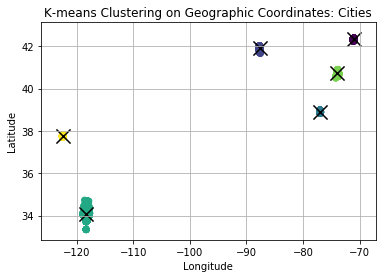

In [69]:
from sklearn.cluster import KMeans

# 6 cities are expected. 
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=1, n_jobs=-1)

# Run clustering algorithm on only coordinates.
kmeans.fit(df_coordinates.loc[:, ['longitude', 'latitude']])

# Visualize coordinates, color-coded by city, with centroids to check clustering.
centroids = kmeans.cluster_centers_
plt.scatter(df_coordinates.loc[:,'longitude'], df_coordinates.loc[:,'latitude'], 
            c=df_coordinates.loc[:,'city_codes'])
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=200, linewidths=3, color='k')
plt.title('K-means Clustering on Geographic Coordinates: Cities')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In the above plot, each concentration of colored city points receives one centroid as expected. 

* Two on the West Coast near longitude 120°W for San Francisco and Los Angeles
* One in the Midwest near longitude 90°W for Chicago
* Three along the East Coast between 80°W and 70°W for Washington DC, New York City, and Boston

The idea suggested in the introduction to this section can be implemented by entering a given number of regions to the n_clusters argument instead of the known number of cities. This is demonstrated below, where the graph displays centroids for the three US regions mentioned in the bullet points.

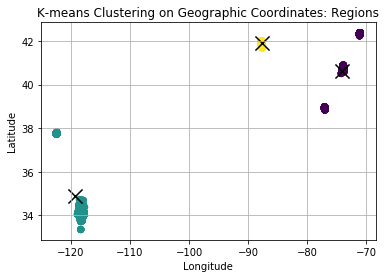

In [71]:
# 3 regions of the US.
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=1, n_jobs=-1)

# Run clustering algorithm on only coordinates.
kmeans.fit(df_coordinates.loc[:, ['longitude', 'latitude']])

# Visualize coordinates, color-coded by k-means cluster labels and centroids.
centroids = kmeans.cluster_centers_
plt.scatter(df_coordinates.loc[:,'longitude'], df_coordinates.loc[:,'latitude'], 
            c=kmeans.labels_)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=200, linewidths=3, color='k')
plt.title('K-means Clustering on Geographic Coordinates: Regions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()